# EDA, Classification pipelines and CatBoost

In this notebook:

* we will do Exploratory Data Analysis
* we will train a lot of pipelines to solve classification task
* we will use CatBoost option to encode categorical features


This dataset contains information on all 802 Pokemon from all Seven Generations of Pokemon. The information contained in this dataset include Base Stats, Performance against Other Types, Height, Weight, Classification, Egg Steps, Experience Points, Abilities, etc. 

https://www.kaggle.com/rounakbanik/pokemon

Is it possible to build a classifier to identify legendary Pokemon?

https://www.kaggle.com/ash316/learn-pandas-with-pokemons

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('Pokemon.csv')

In [4]:
data

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


Columns description (it's crucial!)


- #: ID for each pokemon
- Name: Name of each pokemon
- Type 1: Each pokemon has a type, this determines weakness/resistance to attacks
- Type 2: Some pokemon are dual type and have 2
- Total: sum of all stats that come after this, a general guide to how strong a pokemon is
- HP: hit points, or health, defines how much damage a pokemon can withstand before fainting
- Attack: the base modifier for normal attacks (eg. Scratch, Punch)
- Defense: the base damage resistance against normal attacks
- SP Atk: special attack, the base modifier for special attacks (e.g. fire blast, bubble beam)
- SP Def: the base damage resistance against special attacks
- Speed: determines which pokemon attacks first each round

In [5]:
# fillna and drop useless cols

display(data.isnull().sum())
data['Type 2'] = data['Type 2'].fillna('No 2nd type')

data.drop(columns=['#', 'Name'], inplace=True)

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [6]:
X = data.drop(columns='Legendary')
y = data['Legendary'].astype('int')

In [7]:
y.value_counts(normalize=True)

0    0.91875
1    0.08125
Name: Legendary, dtype: float64

# Exploratory Data Analysis

* exploratory data analysis (EDA) is used by data scientists to analyze and investigate data sets and summarize their main characteristics, often employing data visualization methods
* it helps determine how best to manipulate data sources to get the answers you need, making it easier for data scientists to discover patterns, spot anomalies, test a hypothesis, or check assumptions

The attack distribution for the pokemons across all the genarations

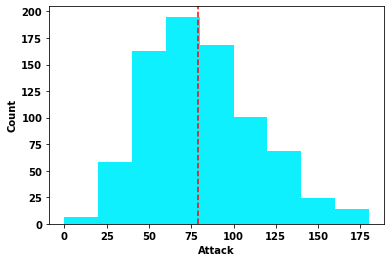

In [8]:
bins = range(0,200,20) #they act as containers
plt.hist(data["Attack"],bins,histtype="bar",rwidth=1.2,color='#0ff0ff') #hist() is used to plot a histogram
plt.xlabel('Attack') #set the xlabel name
plt.ylabel('Count') #set the ylabel name
plt.plot()
plt.axvline(data['Attack'].mean(),linestyle='dashed',color='red') #draw a vertical line showing the average Attack value
plt.show()

Above is a Histogram showing the distribution of attacks for the Pokemons. The average value is between 75-77

### Fire Vs Water

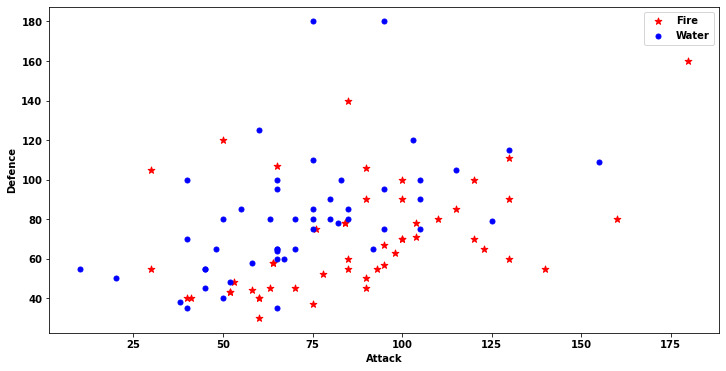

In [9]:
fire  = data[(data['Type 1']=='Fire') | ((data['Type 2'])=="Fire")] #fire contains all fire pokemons
water = data[(data['Type 1']=='Water') | ((data['Type 2'])=="Water")]  #all water pokemins
plt.scatter(fire.Attack.head(50), fire.Defense.head(50),color='R',label='Fire',marker="*",s=50) #scatter plot
plt.scatter(water.Attack.head(50), water.Defense.head(50),color='B',label="Water",s=25)
plt.xlabel("Attack")
plt.ylabel("Defence")
plt.legend()
plt.plot()
fig=plt.gcf()  #get the current figure using .gcf()
fig.set_size_inches(12,6) #set the size for the figure
plt.show()

This shows that fire type pokemons have a better attack than water type pokemons but have a lower defence than water type.

### Strongest Pokemons By Types

In [10]:
strong = data.sort_values(by='Total', ascending=False) #sorting the rows in descending order
strong.drop_duplicates(subset=['Type 1'],keep='first') #since the rows are now sorted in descending oredr
#thus we take the first row for every new type of pokemon i.e the table will check TYPE 1 of every pokemon
#The first pokemon of that type is the strongest for that type
#so we just keep the first row

,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
426,Dragon,Flying,780,105,180,100,180,100,115,3,True
164,Psychic,No 2nd type,780,106,150,70,194,120,140,1,True
422,Water,No 2nd type,770,100,150,90,180,160,90,3,True
424,Ground,Fire,770,100,180,160,150,90,90,3,True
552,Normal,No 2nd type,720,120,120,120,120,120,120,4,True
413,Steel,Psychic,700,80,145,150,105,110,110,3,False
268,Rock,Dark,700,100,164,150,95,120,71,2,False
545,Ghost,Dragon,680,150,120,100,120,100,90,4,True
270,Fire,Flying,680,106,130,90,110,154,90,2,True
792,Fairy,No 2nd type,680,126,131,95,131,98,99,6,True


### Distribution of various pokemon types

In [11]:
types_1 = data['Type 1'].value_counts()
types_1

Water       112
Normal       98
Grass        70
Bug          69
Psychic      57
Fire         52
Rock         44
Electric     44
Ground       32
Ghost        32
Dragon       32
Dark         31
Poison       28
Steel        27
Fighting     27
Ice          24
Fairy        17
Flying        4
Name: Type 1, dtype: int64

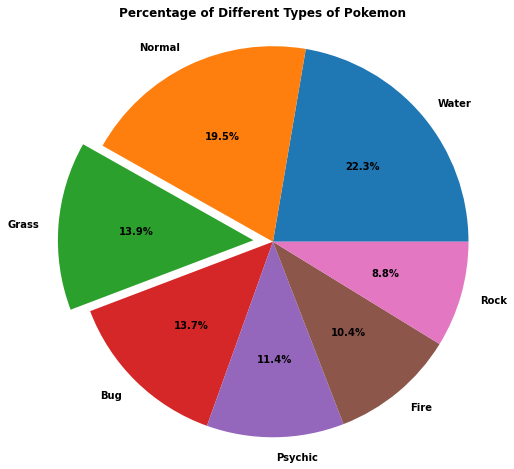

In [12]:
labels = types_1.index[:7]
sizes = types_1.values[:7]

explode = np.zeros(len(labels))
explode[2] = 0.1

plt.figure(figsize=(8,8))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title("Percentage of Different Types of Pokemon")
plt.plot()
plt.show()

### Stats analysis of the pokemons

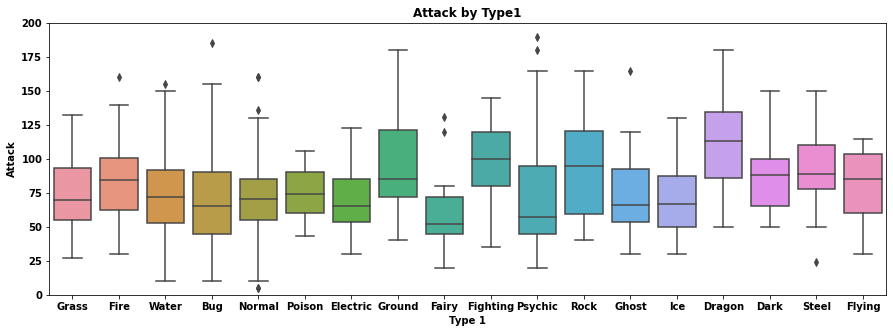

In [13]:
plt.subplots(figsize = (15,5))
plt.title('Attack by Type1')
sns.boxplot(x = "Type 1", y = "Attack",data = data)
plt.ylim(0,200)
plt.show()

This shows that the Dragon type pokemons have an edge over the other types as they have a higher attacks compared to the other types. Also since the fire pokemons have lower range of values, but higher attacks, they can be preferred over the grass and water types for attacking.

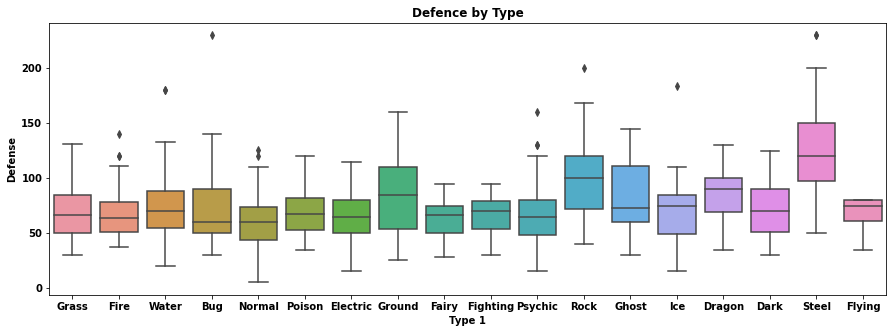

In [14]:
plt.subplots(figsize = (15,5))
plt.title('Defence by Type')
sns.boxplot(x = "Type 1", y = "Defense",data = data)
plt.show()

This shows that steel type pokemons have the highest defence but normal type pokemons have the lowest defence

### Let's analyze generations

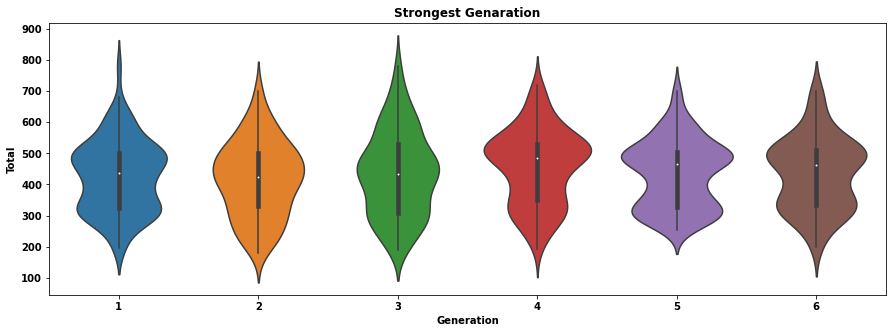

In [15]:
plt.subplots(figsize = (15,5))
plt.title('Strongest Genaration')
sns.violinplot(x = "Generation", y = "Total",data = data)
plt.show()

This shows that generation 3 has the better pokemons

### Finding any Correlation between the attributes

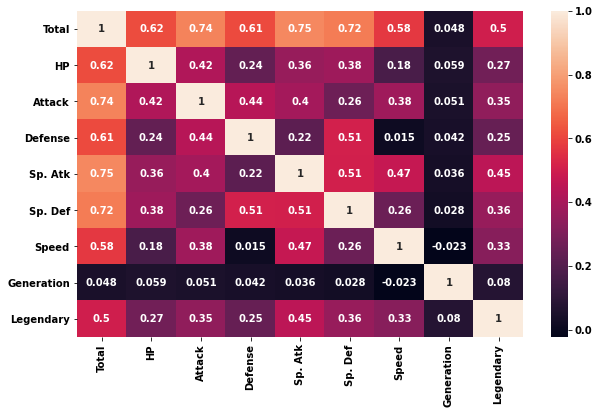

In [16]:
plt.figure(figsize=(10,6)) #manage the size of the plot
sns.heatmap(data.corr(),annot=True) #df.corr() makes a correlation matrix and sns.heatmap is used to show the correlations heatmap
plt.show()

From the heatmap it can be seen that there is not much correlation between the attributes of the pokemons. The highest we can see is the correlation between Sp.Atk and the Total

# Make some default pipeline

*The Pipeline constructor from sklearn allows you to chain transformers and estimators together into a sequence that functions as one cohesive unit.* For example, if your model involves feature selection, standardization, and then regression, those three steps, each as it's own class, could be encapsulated together via Pipeline.

In our baseline (simple pipeline) we will take the following steps:

* encode categorical data via OneHotEncoding
* normalize data (scale data) 
* apply simple linear classification model

In [17]:
from sklearn.pipeline import Pipeline
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

In [18]:
# define cat_cols

cat_cols = ['Type 1', 'Type 2']

default_pipeline = Pipeline([
    ('cat_encoder_', OneHotEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', LogisticRegression())]
)

In [19]:
cv_res1 = cross_validate(default_pipeline,
                        X,
                        y,
                        cv=5,
                        scoring='f1',
                        n_jobs=-1,
                        return_train_score=True
                       )

In [20]:
cv_res1['test_score'].mean()

0.44874141876430207

# Make pipeline more complicated

Ways to do it:

1) **Apply other categorical encoder**:

    * LeaveOneOutEncoder
    
    * TargetEncoder
    
    * WOEEncoder
    
    etc. https://contrib.scikit-learn.org/category_encoders/
  
2) **Create new features**, for example, using PolynomialFeatures of a certain degree.

3) **Select important features from new high-dimensional feature space**:

    * Univariate feature selection
    
    * Recursive feature elimination
    
    * Model-based feature selection
    
4) **Try different models**:

    * Linear models: SVM, LogisticRegression
    
    * Non-linear models: KNN, DecisionTree
    
    * Ensembles: RandomForest, GradientBoosting (CatBoost)

In [21]:
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders import TargetEncoder, WOEEncoder, MEstimateEncoder

Let's try different categorical encoders.

In [22]:
for encoder in [OneHotEncoder, LeaveOneOutEncoder, WOEEncoder, MEstimateEncoder]:
    
    pipe_dif = Pipeline([
        ('cat_encoder_', encoder(cols=cat_cols)),
        ('scaler_', StandardScaler()),
        ('model_', LogisticRegression())]
    )

    cv_res2 = cross_validate(pipe_dif,
                            X,
                            y,
                            cv=5,
                            scoring='f1',
                            n_jobs=-1,
                            return_train_score=True
                           )

    print(encoder.__name__, cv_res2['test_score'].mean())

OneHotEncoder 0.44874141876430207
LeaveOneOutEncoder 0.5903571428571428
WOEEncoder 0.5639359108324625
MEstimateEncoder 0.5432083973374296


Let's add polynomial features.

We will use LeaveOneOutEncoder since it gives us the best score.

In [23]:
from sklearn.preprocessing import PolynomialFeatures

In [24]:
pipe_poly = Pipeline([
    ('cat_encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('poly_featurizer_', PolynomialFeatures(degree=4)),
    ('scaler_', StandardScaler()),
    ('model_', LogisticRegression())]
)

cv_res3 = cross_validate(pipe_poly,
                        X,
                        y,
                        cv=5,
                        scoring='f1',
                        n_jobs=-1,
                        return_train_score=True
                       )

print('train_score:', cv_res3['train_score'].mean())
print('test_score:', cv_res3['test_score'].mean())

train_score: 0.9454213660937036
test_score: 0.6098689981042922


Well, the test score increased... But we have an overfitted model!

# Apply feature selectors

In [29]:
from sklearn.feature_selection import SelectKBest

In [30]:
data_tr = pipe_poly[:-1]

In [31]:
data_tr

Pipeline(steps=[('cat_encoder_', LeaveOneOutEncoder(cols=['Type 1', 'Type 2'])),
                ('poly_featurizer_', PolynomialFeatures(degree=4)),
                ('scaler_', StandardScaler())])

In [32]:
X_tr = data_tr.fit_transform(X, y)
print(f'data shape after transformation is {X_tr.shape}')

data shape after transformation is (800, 1001)


We have a lot of features, that's why we overfit! Let's now select some important features.

## Фильтрационные методы

Суть таких методов в том, чтобы для каждого признака посчитать некоторую метрику "связи" с целевым признаком. И в результате оставить топ-K признаков согласно выбранной метрике.

В том числе на лекции обсуждались:

 - статистика хи-квадрат
 - метрика mutual information

In [33]:
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif

In [59]:
k_best = 20
# it's a random choice for demonstration only, but we need to choose k_best via GridSearch.

pipe = Pipeline([
    ('cat_encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('poly_featurizer_', PolynomialFeatures(degree=4)),
    ('scaler_', StandardScaler()),
    ('selector_', SelectKBest(score_func=mutual_info_classif, k=k_best)), 
    ('model_', LogisticRegression())]
)

In [60]:
cv_res = cross_validate(pipe, X, y, cv=5, scoring='f1', return_train_score=True)
cv_res

cv_res['test_score'].mean()

0.5186381357433989

## Жадный метод отбора

In [61]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [62]:
rfe = RFE(LogisticRegression(max_iter=1000), n_features_to_select=k_best, step=30)

In [63]:
X_tr.shape

(800, 1001)

In [64]:
res = rfe.fit_transform(X_tr, y)
display(res.shape)

(800, 20)

In [65]:
pipe_rfe = Pipeline([
    ('cat_encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('poly_featurizer_', PolynomialFeatures(degree=4)),
    ('scaler_', StandardScaler()),
    ('selector_', RFE(LogisticRegression(max_iter=1000),
                      n_features_to_select=k_best,
                      step=30
                     )), 
    ('model_', LogisticRegression())])

In [66]:
cv_res3 = cross_validate(pipe_rfe, X, y, cv=5, scoring='f1', return_train_score=True)
cv_res3['test_score'].mean()

0.6254010695187165

## С помощью L1 регуляризации

In [67]:
from sklearn.feature_selection import SelectFromModel

In [68]:
sel = SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'), threshold=1e-5)

In [69]:
# пример

res = sel.fit_transform(X_tr, y)
display(res.shape)

(800, 49)

In [70]:
pipe_lasso =  Pipeline([
    ('cat_encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('poly_featurizer_', PolynomialFeatures(degree=4)),
    ('scaler_', StandardScaler()),
    ('selector_', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'), 
                                  threshold=1e-5)), 
    ('model_', LogisticRegression())])

In [71]:
cv_res4 = cross_validate(pipe_lasso, X, y, cv=5, scoring='f1', return_train_score=True)
cv_res4['test_score'].mean()

0.6355895085306849

# PCA или метод главных компонент

Цель: создать k новых признаков из какого-либо количества старых признаков, так чтобы 
- каждый из новых признаков был линейной комбинацией старых

$z_i = u_1x_{1i} + ... + u_lx{li}$

- и дисперсия $z_i$, то есть новых признаков была максимальной (наиболее информативной)

In [94]:
from sklearn.decomposition import PCA

In [95]:
# пример

pca = PCA(n_components = 5)

res = pca.fit_transform(X_tr, y)
display(res.shape)

(800, 5)

In [96]:
n_components = 5

pipe_pca = Pipeline([
    ('cat_encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('poly_featurizer_', PolynomialFeatures(degree=4)),
    ('scaler_', StandardScaler()),
    ('selector_', PCA(n_components=n_components)), 
    ('model_', LogisticRegression())])

cv_res5 = cross_validate(pipe_pca, X, y, cv=5, scoring='f1', return_train_score=True)
cv_res5['test_score'].mean()

0.5643967932000387

Let's try other models.

* we will select LeaveOneOutEncoder since it is the best option
* we will select SelectFromModel for feature selection for the same reasons

In [98]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier

for model in [SVC(kernel='linear'), LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier(), \
             GradientBoostingClassifier(), CatBoostClassifier(verbose=False)]:
    pipe_lasso =  Pipeline([
        ('cat_encoder_', LeaveOneOutEncoder(cols=cat_cols)),
        ('poly_featurizer_', PolynomialFeatures(degree=4)),
        ('scaler_', StandardScaler()),
        ('selector_', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'), 
                                      threshold=1e-5)), 
        ('model_',model)])

    cv_res4 = cross_validate(pipe_lasso, X, y, cv=5, scoring='f1', return_train_score=True)
    print(model, cv_res4['test_score'].mean())

SVC(kernel='linear') 0.6452723223890271
LogisticRegression() 0.6355895085306849
KNeighborsClassifier() 0.5157626687038451
RandomForestClassifier() 0.498992673992674
GradientBoostingClassifier() 0.6026982773785843
<catboost.core.CatBoostClassifier object at 0x000001EB3482B188> 0.47479296066252585


## Let's give a chance to CatBoost.

Find optimal number of trees.

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [04:14<00:00,  6.37s/it]


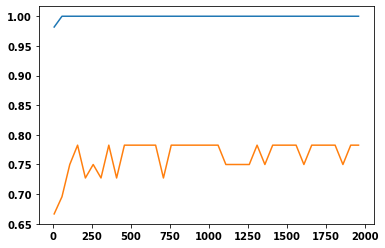

In [102]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

f1_train = []
f1_test = []

max_test = -1
optimal_n = -1

pipe_pre =  Pipeline([
    ('cat_encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('poly_featurizer_', PolynomialFeatures(degree=4)),
    ('scaler_', StandardScaler()),
    ('selector_', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'), 
                                      threshold=1e-5))])

X_train_new = pipe_pre.fit_transform(X_train, y_train)
X_test_new = pipe_pre.transform(X_test)

for n_estimators in tqdm(np.arange(10, 2000, 50)):

    model = CatBoostClassifier(n_estimators = n_estimators, verbose=False)
    model.fit(X_train_new, y_train)
    
    train_pred = model.predict(X_train_new)
    test_pred = model.predict(X_test_new)
    
    if f1_score(y_test, test_pred) > max_test:
        max_test = f1_score(y_test, test_pred)
        optimal_n = n_estimators

    f1_train.append(f1_score(y_train, train_pred))
    f1_test.append(f1_score(y_test, test_pred))

n_list = np.arange(10, 2000, 50)
plt.plot(n_list, f1_train, label='CatBoost train')    
plt.plot(n_list, f1_test, label='CatBoost test')    
plt.show()

In [103]:
optimal_n, max_test

(160, 0.7826086956521738)

We can see that catboost doesn't overfit! The best n_estimators is about 160 with f1-score = 0.783.

Let's evaluate this model using cross-validation.

In [109]:
pipe_cb =  Pipeline([
    ('cat_encoder_', LeaveOneOutEncoder(cols=cat_cols)),
    ('poly_featurizer_', PolynomialFeatures(degree=4)),
    ('scaler_', StandardScaler()),
    ('selector_', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'), 
                                  threshold=1e-5)), 
    ('model_',CatBoostClassifier(n_estimators=optimal_n, verbose=False))])

cv_res5 = cross_validate(pipe_cb, X, y, cv=5, scoring='f1', return_train_score=True)
print(model, cv_res5['test_score'].mean())

<catboost.core.CatBoostClassifier object at 0x000001EB3571DCC8> 0.5110041407867495


In [107]:
cv_res4['test_score']

array([0.375     , 0.88888889, 0.5       , 0.43478261, 0.26086957])

Score depends a lot on the split. We can see it. Let's stop here and try catboost features!

CatBoost can encode categorical features itself. Let's try to do it.

In [110]:
cat_features = [0, 1]

cv_res6 = cross_validate(CatBoostClassifier(n_estimators=300, cat_features=cat_features, verbose=False),\
                                            X, y, cv=5, scoring='f1', return_train_score=True)
print(cv_res6['test_score'].mean())

0.7059454191033139


Now we will find n_estimators and learning_rate via GridSearchCV.

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' : np.arange(300,400,20),
          'learning_rate' : [0.01, 0.05, 0.1]}

gs = GridSearchCV(CatBoostClassifier(cat_features=[0,1], verbose=False), params, cv=5, scoring='f1')
gs.fit(X, y)

In [ ]:
gs.best_score_, gs.best_params_

Let's go deeper and find optimal max_depth.

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth' : np.arange(2,15)}

gs2 = GridSearchCV(CatBoostClassifier(n_estimators=340, learning_rate=0.05, cat_features=[0,1], verbose=False), \
                   params, cv=5, scoring='f1')
gs2.fit(X, y)

gs2.best_score_, gs2.best_params_

Profit!